# Concept Network Tool

## Import data

Here user has to define the following:

- `DATA_PATH`: the folder including data files
- `DATA_FILES` : automatically detected `csv` files from `DATA_PATH` 


In [1]:
# Load R packages
pacman::p_load(tidyverse, udpipe, stopwords)

In [2]:
DATA_PATH <- "processed_data"
DATA_FILES <- list.files(DATA_PATH, pattern = ".csv",full.names = TRUE,)

cat("Available datasets in", DATA_PATH, "\n",
    
    paste(paste(1:length(DATA_FILES) ,"\t", DATA_FILES, "\n"), sep = "\n"), "\n")


df_path <- DATA_FILES[as.numeric(readline(prompt="Select data: "))]
df_raw <- read.csv(df_path)
cat(df_path, "selected.")

Available datasets in processed_data 
 1 	 processed_data/hs2014_processed.csv 
 
Select data: 1
processed_data/hs2014_processed.csv selected.

## Defining question and its concepts

### Option 1 – Interactively selected concepts

In [4]:
question <- readline(prompt="What is the question that was asked from the respondents?\n")
input_concepts <- readline(prompt="What are the concepts in this question? Separate multiple concepts with a comma.\n")
concepts <- trimws(stringr::str_split(input_concepts, ",", simplify = TRUE), "both")

cat("Following concepts selected:\n",
   paste(paste(1:length(concepts) ,"\t", concepts, "\n"), sep = "\n"), "\n")

What is the question that was asked from the respondents?
Miltä yksinäisyys tuntuu?
What are the concepts in this question? Separate multiple concepts with a comma.
yksinäisyys, yksinäisyyden tunne
Following concepts selected:
 1 	 yksinäisyys 
 2 	 yksinäisyyden tunne 
 


### Option 2 – Manually assigned variables

In [3]:
question = "Miltä yksinäisyys tuntuu? Yksinäisyyteen liittyy usein voimakkaita tunteita, jotka ovat erilaisia eri elämäntilanteissa. Jos haluat, voit kertoa yksinäisyyskokemuksiasi tässä"
concepts = c("yksinäisyys", "yksinäisyys tunne")

cat("Following concepts selected:\n",
   paste(paste(1:length(concepts) ,"\t", concepts, "\n"), sep = "\n"), "\n")

Following concepts selected:
 1 	 yksinäisyys 
 2 	 yksinäisyys tunne 
 


## Stopword removal

R package [`stopwords`](https://cran.r-project.org/web/packages/stopwords/readme/README.html) includes three Finnish stop word lists: 

    1. snowball
    2. nltk
    3. stopwords-iso


Then filter the data by excluding words from the stop word list.

In [16]:
sw_lists_available <- stopwords_getsources()[unlist(lapply(stopwords_getsources(), function(x) ifelse("fi" %in% stopwords_getlanguages(x), TRUE, FALSE)))]
sw_lists <- c(lapply(sw_lists_available, function(y) stopwords("fi", y)), list(NA))
sw_list_sizes <- lapply(sw_lists, function(z) ifelse(length(z) > 1, length(z), 0))
                
sw_options <- c(paste(c(sw_lists_available, "None"), paste0("(", sw_list_sizes, " words)")), "Custom")
                        
cat("Stopword lists available:\n",paste(paste(1:length(sw_options) ,"\t", sw_options, "\n"), sep = "\n"), "\n")

sw_selection <- readline(prompt="Select stopword list: ")                        

if(as.numeric(sw_selection) == length(sw_options)) {
    custom_stopwords <- readline(prompt="List all stopwords. Separate with a comma.\n")
    stopword_list <- trimws(stringr::str_split(custom_stopwords, ",", simplify = TRUE), "both")
    cat(length(stopword_list), "stopwords saved.")
} else {
    stopword_list <- sw_lists[[as.numeric(sw_selection)]]
    cat("Stopwords:\n", paste(stopword_list, collapse = ", "), sep ="")
}
                        
                     

Stopword lists available:
 1 	 snowball (68 words) 
 2 	 stopwords-iso (847 words) 
 3 	 nltk (229 words) 
 4 	 None (0 words) 
 5 	 Custom 
 
Select stopword list: 3
Stopwords:
olla, olen, olet, on, olemme, olette, ovat, ole, oli, olisi, olisit, olisin, olisimme, olisitte, olisivat, olit, olin, olimme, olitte, olivat, ollut, olleet, en, et, ei, emme, ette, eivät, minä, minun, minut, minua, minussa, minusta, minuun, minulla, minulta, minulle, sinä, sinun, sinut, sinua, sinussa, sinusta, sinuun, sinulla, sinulta, sinulle, hän, hänen, hänet, häntä, hänessä, hänestä, häneen, hänellä, häneltä, hänelle, me, meidän, meidät, meitä, meissä, meistä, meihin, meillä, meiltä, meille, te, teidän, teidät, teitä, teissä, teistä, teihin, teillä, teiltä, teille, he, heidän, heidät, heitä, heissä, heistä, heihin, heillä, heiltä, heille, tämä, tämän, tätä, tässä, tästä, tähän, tallä, tältä, tälle, tänä, täksi, tuo, tuon, tuotä, tuossa, tuosta, tuohon, tuolla, tuolta, tuolle, tuona, tuoksi, se, sen, sitä,

In [18]:
# Remove all the stop words above from the data
df <- df_raw %>%
  filter(!lemma %in% stopword_list) 

# Background processing 
## Document Term Matrix

In [19]:
vocab = df %>% 
    filter(!xpos %in% c("Punct", "Symb"))%>% 
    pull(lemma) %>%
    unique()
cat(length(vocab), "words in vocabulary.")

term_frequencies <- document_term_frequencies(df %>% select(doc_id, lemma))
dtm = document_term_matrix(term_frequencies, vocabulary = vocab)


7734 words in vocabulary.

## Word frequencies for concept words

In [20]:
concept_counts <- function(dtm, concepts) {
    concept_list <- str_split(concepts, " ")
    
    output <- lapply(concept_list, function(i) {
        word_counts <- lapply(i, function(j){ifelse(j %in% colnames(dtm), sum(dtm[,j]) , NA)})
        df_words <- data.frame(term = i, count = unlist(word_counts))
        
    })
    
    names(output) <- concepts
    
    return(output)
}

## Word co-occurences 

In [21]:
get_cooccurences <- function(data, concepts) {
    
    concept_list <- unlist(str_split(concepts, " "))
    
    cleaned_data <- data %>% 
    filter(!xpos %in% c("Punct", "Symb"))
    
    counts <- cooccurrence(cleaned_data, group = "doc_id", term = "lemma")
    
    concept_counts <- counts[counts$term1 %in% concept_list | counts$term2 %in% concept_list,]
    
    return(concept_counts)
}

concept_cooccurences <- get_cooccurences(data = df, concepts = concepts)

## Context words for concept words

In [22]:
search_context_words <- function(data, concepts, size = 5) {
    concept_list <- str_split(concepts, " ")    
    
    cleaned_data <- data %>% 
    filter(!xpos %in% c("Punct", "Symb"))%>% 
    group_by(doc_id, paragraph_id, sentence_id) %>% 
    mutate(token_id = row_number(sentence_id))
    
    concept_words <- cleaned_data %>%
    filter(lemma %in% unlist(concept_list) | token %in% unlist(concept_list))
    
    
    get_window <- function(token_id, size) {

        indices <- lapply(token_id, function(x){
            start <- ifelse(x - size >= 1, x - size, 0)
            end <- x + size

            return(start:end)
        })
        return(indices)
    }
    
    concept_locations <- concept_words %>%
    tibble() %>%
    select(lemma, doc_id, sentence_id, token_id) %>%
    mutate(window = get_window(token_id, size = size)) %>%
    unnest_longer(window) %>%
    rename(concept_location = token_id, token_id = window, concept = lemma)
    
    context_windows <- concept_locations %>% 
    inner_join(cleaned_data, by = c("doc_id", "sentence_id", "token_id")) 
    
    
    return(context_windows)
}

context_windows <- search_context_words(data = df, concepts = concepts)

In [23]:
context_words_counts <- context_windows %>% 
    group_by(concept) %>% 
    count(lemma, sort = TRUE) %>%
    group_split()

# Visualization

## Word Networks

Set the limit for minimum number of co-occurences? 
300


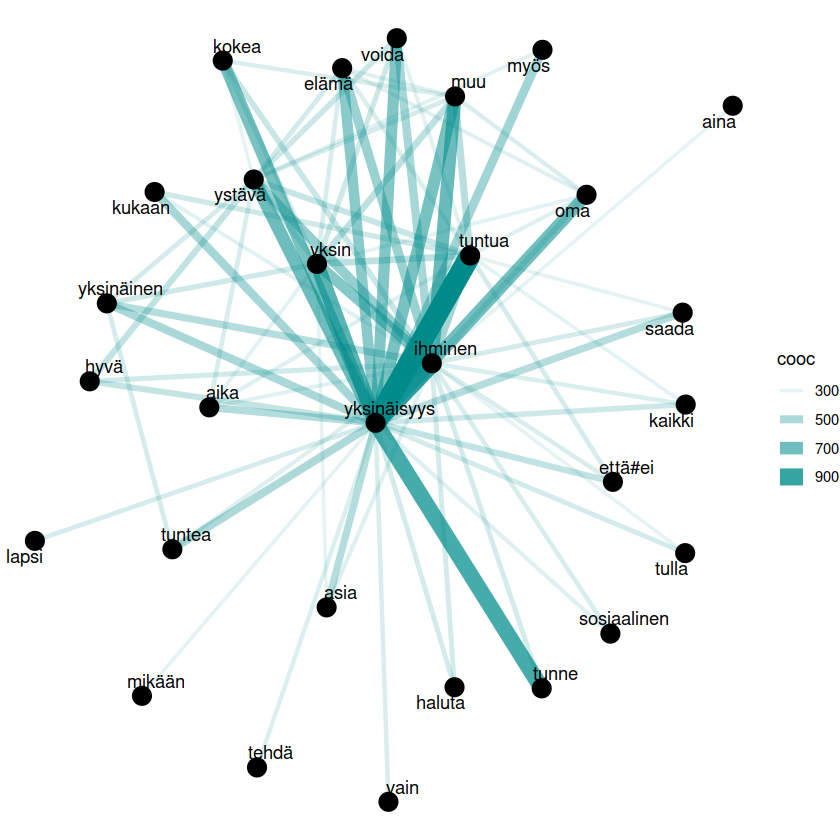

In [46]:
library(igraph)
library(ggraph)

threshold <- as.numeric(readline(prompt="Set the limit for minimum number of co-occurences? \n"))
#threshold <- 300

df %>%
    filter(!xpos %in% c("Punct", "Symb")) %>%
    cooccurrence(, group = "doc_id", term = "lemma") %>%
    data.frame() %>%
    filter(cooc>= threshold) %>%
    graph_from_data_frame() %>%
    ggraph(layout = "kk") +
    geom_edge_link(aes(edge_alpha = cooc, edge_width = cooc), edge_colour = "cyan4") +
    geom_node_point(size = 5) +
    geom_node_text(aes(label = name), repel = TRUE, 
                 point.padding = unit(0.2, "lines")) +
    theme_void()